In [1]:
# Widen width of notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# ML Practice Part 1

We are going to build a classifer to tag cuisine type from ingredients. It can be the smart tagging feature in those marketplace companies to help merchants. 


## Agenda

1. Reading in and exploring the data
2. Feature engineering
3. Model evaluation using **`train_test_split`** and **`cross_val_score`**
4. Making predictions for new data
5. Searching for optimal tuning parameters using **`GridSearchCV`**
6. Extracting features from text using **`CountVectorizer`**
7. Chaining steps into a **`Pipeline`**

In [2]:
# for Python 2: use print only as a function
from __future__ import print_function

In [3]:
import pandas as pd
pd.set_option('max_colwidth', 100)

## Part 1: Reading in and exploring the data

In [4]:
train = pd.read_json('../data/cuisine_data/train.json')
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanz..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, y..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powd..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, le..."


In [5]:
train.shape

(39774, 3)

In [6]:
# count the number of null values in each column
train.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

In [7]:
train.dtypes

id              int64
cuisine        object
ingredients    object
dtype: object

In [8]:
# select row 0, column 'ingredients'
train.loc[0, 'ingredients']

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

In [9]:
# ingredients are stored as a list of strings, not as a string
type(   train.loc[0, 'ingredients']   )

list

In [10]:
# examine the class distribution
train.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

### Target: Predict Cuisine
### Input:   Ingredients

## Part 2: Feature engineering

- Feature engineering is the process through which you create features that **don't natively exist** in the dataset.
- Your goal is to create features that contain the **signal** from the data (with respect to the response value), rather than the **noise**.
- Recall that computers only understand numbers (binary)

### Example: Number of ingredients

In [11]:
# count the number of ingredients in each recipe
train['num_ingredients'] = train.ingredients.apply(len)
train.head()

,id,cuisine,ingredients,num_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanz...",9
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, y...",11
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powd...",12
3,22213,indian,"[water, vegetable oil, wheat, salt]",4
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, le...",20


In [12]:
# for each cuisine, calculate the mean number of ingredients
train.groupby('cuisine').num_ingredients.mean()

cuisine
brazilian        9.520343
british          9.708955
cajun_creole    12.617076
chinese         11.982791
filipino        10.000000
french           9.817838
greek           10.182128
indian          12.705961
irish            9.299850
italian          9.909033
jamaican        12.214829
japanese         9.735067
korean          11.284337
mexican         10.877446
moroccan        12.909866
russian         10.224949
southern_us      9.634954
spanish         10.423660
thai            12.545809
vietnamese      12.675152
Name: num_ingredients, dtype: float64

In [13]:
# Alternative way of doing it
#train.groupby('cuisine')['num_ingredients'].mean()

In [14]:
# for each cuisine, "describe" the number of ingredients (and unstack into a DataFrame)
train.groupby('cuisine').num_ingredients.describe() #.unstack()

,count,mean,std,min,25%,50%,75%,max
cuisine,,,,,,,,
brazilian,467.0,9.520343,5.555139,2.0,5.0,9.0,13.0,59.0
british,804.0,9.708955,4.165011,2.0,7.0,9.0,12.0,30.0
cajun_creole,1546.0,12.617076,4.611601,2.0,9.0,12.0,16.0,31.0
chinese,2673.0,11.982791,4.042125,2.0,9.0,12.0,14.0,38.0
filipino,755.0,10.000000,3.855135,2.0,7.0,10.0,12.0,38.0
french,2646.0,9.817838,4.144744,1.0,7.0,9.0,12.0,31.0
greek,1175.0,10.182128,3.729461,1.0,7.0,10.0,12.0,27.0
indian,3003.0,12.705961,5.016806,1.0,9.0,12.0,16.0,49.0
irish,667.0,9.299850,3.700505,2.0,7.0,9.0,12.0,27.0


In [15]:
# allow plots to appear in the notebook
%matplotlib inline

<AxesSubplot: title={'center': 'num_ingredients'}, xlabel='cuisine'>

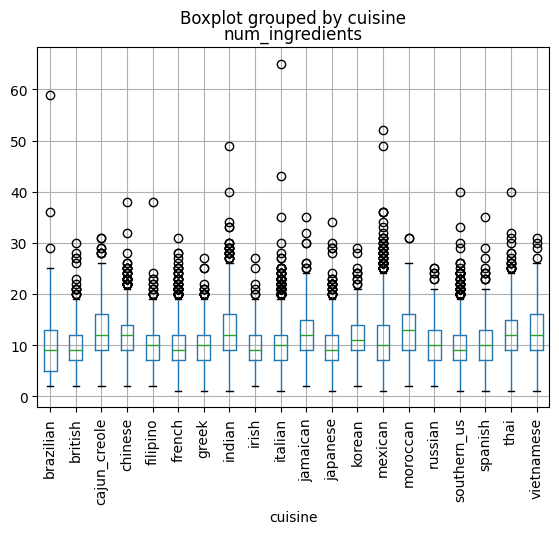

In [16]:
# box plot of number ingredients for each cuisine
train.boxplot('num_ingredients', by='cuisine', rot=90)

### Example: Mean length of ingredient names

In [17]:
sample_recipe = train.loc[3, 'ingredients']
print(sample_recipe)

['water', 'vegetable oil', 'wheat', 'salt']


In [18]:
import numpy as np

In [19]:
# define a function that calculates the mean string length from a list of strings
def mean_string_length(list_of_strings):
    return np.mean([len(string) for string in list_of_strings])

In [20]:
mean_string_length(sample_recipe)

6.75

In [21]:
# calculate the mean ingredient length for each recipe (two different ways)
train['ingredient_length'] = train.ingredients.apply(mean_string_length)
train['ingredient_length'] = train.ingredients.apply(lambda x: np.mean([len(item) for item in x]))
train.head()

,id,cuisine,ingredients,num_ingredients,ingredient_length
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanz...",9,12.000000
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, y...",11,10.090909
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powd...",12,10.333333
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,6.750000
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, le...",20,10.100000


<AxesSubplot: title={'center': 'ingredient_length'}, xlabel='cuisine'>

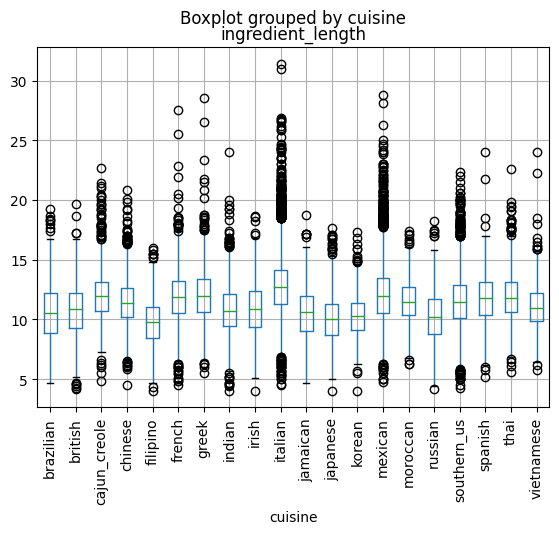

In [22]:
# box plot of mean ingredient length for each cuisine
train.boxplot('ingredient_length', by='cuisine', rot=90)

In [23]:
# define a function that accepts a DataFrame and adds new features
def make_features(df):
    df['num_ingredients'] = df.ingredients.apply(len)
    df['ingredient_length'] = df.ingredients.apply(lambda x: np.mean([len(item) for item in x]))
    return df

In [25]:
# check that the function works
train = make_features( pd.read_json('../data/cuisine_data/train.json') )
train.head()

,id,cuisine,ingredients,num_ingredients,ingredient_length
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanz...",9,12.000000
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, y...",11,10.090909
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powd...",12,10.333333
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,6.750000
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, le...",20,10.100000


## Part 3: Model evaluation using `train_test_split` and `cross_val_score`

- The motivation for model evaluation is that you need a way to **choose between models** (different model types, tuning parameters, and features).
- You use a model evaluation procedure to estimate how well a model will **generalize** to out-of-sample data.
- Avoid underfit and overfit
- This requires a model evaluation metric to **quantify** a model's performance.

<img src="../notebook_imgs/overfit.jpg">

In [26]:
train.head()

,id,cuisine,ingredients,num_ingredients,ingredient_length
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanz...",9,12.000000
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, y...",11,10.090909
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powd...",12,10.333333
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,6.750000
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, le...",20,10.100000


In [27]:
# define X and y
feature_cols = ['num_ingredients', 'ingredient_length']
X = train[feature_cols]
y = train.cuisine

In [28]:
print(type(X))
print(type(y))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [29]:
X.head()

,num_ingredients,ingredient_length
0,9,12.000000
1,11,10.090909
2,12,10.333333
3,4,6.750000
4,20,10.100000


In [30]:
y.head()

0          greek
1    southern_us
2       filipino
3         indian
4         indian
Name: cuisine, dtype: object

In [31]:
print(X.shape)
print(y.shape)

(39774, 2)
(39774,)


In [32]:
# note: response values are strings (not numbers)
y.values

array(['greek', 'southern_us', 'filipino', ..., 'irish', 'chinese',
       'mexican'], dtype=object)

[KNeighborsClassifier documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [33]:
# use KNN with K=100
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=100)

### Train/test split

- Here, test is referred to validation
- Randomization for splitting
- Larger training data size -> better model
- Larger testing data size  -> more confident in model's evaluation
- One practical rule: 10%-25% left for testing

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [35]:
# make class predictions for the testing set
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)

In [36]:
# check the classification accuracy of KNN's predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.22314963797264684

### Here, we are using KNN, which is sensitive to the data scales.

Try feature scalers and re-run the KNN model

https://scikit-learn.org/stable/modules/preprocessing.html


### K-fold cross-validation

- Train/test split is **faster and more flexible**
- Cross-validation provides a **more accurate** estimate of out-of-sample performance
    - Use your initial training data to generate multiple mini train-test splits. Use these splits to evaluate your model 
    - K is a hyper-parameters. K is equal to the number of generated train-test splits
- CV steps:
    - Partition data into k subsets,i.e., folds
    - Iteratively train the model on k-1 folds while using the remaining fold as the test set (holdout)
    - Compute the average performances over the K folds
 
<img src="../notebook_imgs/cv.png">

In [37]:
# evaluate with 5-fold cross-validation (using X instead of X_train)

#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score

cross_val_score(knn, X, y, cv=5, scoring='accuracy').mean()

0.21712669344646235

### Null model

- For **classification** problems, the null model always predicts the most frequent class from the training data.
- For **regression problems**, the null model always predicts the mean of the response value from the training data.
- It can be a useful **baseline model** against which your model is measured.

In [38]:
# calculate the null accuracy
y_test.value_counts().head(1) / y_test.shape

italian    0.199216
Name: cuisine, dtype: float64

[DummyClassifier documentation](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)

In [39]:
# use DummyClassifier instead
from sklearn.dummy import DummyClassifier
dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(X_train, y_train)
y_pred_class = dumb.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.1992156074014481

## Part 4: Making predictions for new data

In [41]:
# read in test.json and add the additional features
new = make_features(pd.read_json('../data/cuisine_data/test.json'))
new.head()

,id,ingredients,num_ingredients,ingredient_length
0,18009,"[baking powder, eggs, all-purpose flour, raisins, milk, white sugar]",6,9.333333
1,28583,"[sugar, egg yolks, corn starch, cream of tartar, bananas, vanilla wafers, milk, vanilla extract,...",11,10.272727
2,41580,"[sausage links, fennel bulb, fronds, olive oil, cuban peppers, onions]",6,9.666667
3,29752,"[meat cuts, file powder, smoked sausage, okra, shrimp, andouille sausage, water, paprika, hot sa...",21,12.000000
4,35687,"[ground black pepper, salt, sausage casings, leeks, parmigiano reggiano cheese, cornmeal, water,...",8,13.000000


In [42]:
new.shape

(9944, 4)

In [43]:
# create a DataFrame of the relevant columns from the new data

feature_cols = ['num_ingredients', 'ingredient_length']

X_new = new[feature_cols]
X_new.head()

,num_ingredients,ingredient_length
0,6,9.333333
1,11,10.272727
2,6,9.666667
3,21,12.000000
4,8,13.000000


In [44]:
X_new.shape

(9944, 2)

In [45]:
# train KNN on ALL of the training data (using X instead of X_train)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=100)

In [46]:
# make class predictions for the new data
new_pred_class_knn = knn.predict(X_new)
new_pred_class_knn

array(['mexican', 'southern_us', 'mexican', ..., 'italian', 'mexican',
       'mexican'], dtype=object)

In [47]:
new_pred_class_knn.shape

(9944,)

In [48]:
# create a DataFrame that only contains the IDs and predicted classes for the new data
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_knn}).set_index('id').head()

,cuisine
id,
18009,mexican
28583,southern_us
41580,mexican
29752,mexican
35687,italian


In [49]:
# create a submission file from that DataFrame (score: 0.21742)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_knn}).set_index('id').to_csv('sub1.csv')

## Part 5: Searching for optimal tuning parameters using `GridSearchCV`

In [50]:
# reminder of the cross-validated accuracy of KNN with K=100
knn = KNeighborsClassifier(n_neighbors=100)
cross_val_score(knn, X, y, cv=5, scoring='accuracy').mean()

0.21712669344646235

[GridSearchCV documentation](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html)

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
# define a "parameter grid" in which the key is the parameter and the value is a list of options to try
param_grid = {}
param_grid['n_neighbors'] = [100, 200]
param_grid

{'n_neighbors': [100, 200]}

In [53]:
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

In [54]:
# run the grid search
grid.fit(X, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=100),
             param_grid={'n_neighbors': [100, 200]}, scoring='accuracy')

In [55]:
# examine the scores for each parameter option
print(grid.best_score_)
print(grid.best_params_)

0.21949001858107117
{'n_neighbors': 200}


In [56]:
for item in (zip(grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'], grid.cv_results_['params'])):
    print(item)

(0.21712669344646235, 0.002036995341704492, {'n_neighbors': 100})
(0.21949001858107117, 0.0025205737019373133, {'n_neighbors': 200})


#### Addressing the "DeprecationWarning"

In [57]:
sorted(list(grid.cv_results_.keys()))

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_n_neighbors',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [58]:
print('mean_test_score:  ', grid.cv_results_['mean_test_score'])
print('std_test_score:   ', grid.cv_results_['std_test_score'])
print('param_n_neighbors:', grid.cv_results_['param_n_neighbors'])
print('params:           ', grid.cv_results_['params'])

mean_test_score:   [0.21712669 0.21949002]
std_test_score:    [0.002037   0.00252057]
param_n_neighbors: [100 200]
params:            [{'n_neighbors': 100}, {'n_neighbors': 200}]


In [59]:
for item in (zip(grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'], grid.cv_results_['params'])):
    print(item)

(0.21712669344646235, 0.002036995341704492, {'n_neighbors': 100})
(0.21949001858107117, 0.0025205737019373133, {'n_neighbors': 200})


#### Continue...

In [60]:
# try K=200 to 1000 (by 200)
param_grid = {}
param_grid['n_neighbors'] = list(range(200, 1001, 200))
param_grid

{'n_neighbors': [200, 400, 600, 800, 1000]}

In [61]:
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

In [62]:
# time the grid search using an IPython "magic function"
%time grid.fit(X, y)

CPU times: user 15.6 s, sys: 363 ms, total: 15.9 s
Wall time: 15.9 s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=100),
             param_grid={'n_neighbors': [200, 400, 600, 800, 1000]},
             scoring='accuracy')

In [63]:
# examine the scores 
print(grid.best_score_)
print(grid.best_params_)

0.22260768431681416
{'n_neighbors': 800}


In [64]:
for avg, std, prm in (zip(grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'], grid.cv_results_['params'])):
    print('mean: %0.3f, std: %0.5f, params: %s' % (avg, std, prm) )

mean: 0.219, std: 0.00252, params: {'n_neighbors': 200}
mean: 0.220, std: 0.00361, params: {'n_neighbors': 400}
mean: 0.223, std: 0.00108, params: {'n_neighbors': 600}
mean: 0.223, std: 0.00210, params: {'n_neighbors': 800}
mean: 0.222, std: 0.00155, params: {'n_neighbors': 1000}


In [65]:
print(grid.cv_results_)

{'mean_fit_time': array([0.03730698, 0.03671536, 0.03719034, 0.03669429, 0.03879375]), 'std_fit_time': array([0.00121668, 0.00079199, 0.00169924, 0.00025905, 0.00225617]), 'mean_score_time': array([0.23340988, 0.4072258 , 0.58954639, 0.77527876, 0.96505589]), 'std_score_time': array([0.00200144, 0.00293799, 0.00339746, 0.00767678, 0.00513601]), 'param_n_neighbors': masked_array(data=[200, 400, 600, 800, 1000],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 200}, {'n_neighbors': 400}, {'n_neighbors': 600}, {'n_neighbors': 800}, {'n_neighbors': 1000}], 'split0_test_score': array([0.21822753, 0.22023884, 0.2212445 , 0.22199874, 0.22149591]), 'split1_test_score': array([0.22174733, 0.2265242 , 0.22438718, 0.22526713, 0.22313011]), 'split2_test_score': array([0.22250157, 0.22023884, 0.2230044 , 0.22489001, 0.22413576]), 'split3_test_score': array([0.2194846 , 0.2194846 , 0.22199874, 0.22023884, 0.21961031])

In [85]:
# new way
grid_mean_scores = [result for result in grid.cv_results_['mean_test_score']]
grid_mean_scores

[0.21949001858107117,
 0.22034482055603505,
 0.22253229482472045,
 0.22260768431681416,
 0.22197917093052494]

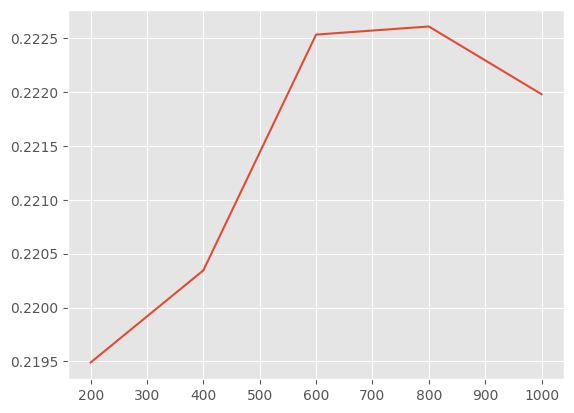

In [86]:
# line plot of K value (x-axis) versus accuracy (y-axis)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(list(range(200, 1001, 200)), grid_mean_scores)

In [87]:
# print the single best score and parameters that produced that score
print(grid.best_score_)
print()
print(grid.best_params_)
print()
print(grid.best_estimator_)

0.22260768431681416

{'n_neighbors': 800}

KNeighborsClassifier(n_neighbors=800)


#### About the"predict" method: call predict on the estimator with the **best found parameters**.
[http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

In [88]:
a_sample = pd.DataFrame({'num_ingredients': [7.1, 1.0, 3.1], 'ingredient_length': [11.2, 10.9, 13.1]})
a_sample

,num_ingredients,ingredient_length
0,7.1,11.2
1,1.0,10.9
2,3.1,13.1


In [89]:
grid.predict( a_sample )

array(['italian', 'italian', 'italian'], dtype=object)

## Part 6: Extracting features from text using `CountVectorizer`

In [90]:
# reminder: ingredients are stored as a list of strings, not as a string
train.loc[0, 'ingredients']

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

In [91]:
# convert each list of ingredients into a string
train.ingredients.astype(str)[0]

"['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']"

In [92]:
# update make_features to create a new column 'ingredients_str'
def make_features(df):
    df['num_ingredients'] = df.ingredients.apply(len)
    df['ingredient_length'] = df.ingredients.apply(lambda x: np.mean([len(item) for item in x]))
    df['ingredients_str'] = df.ingredients.astype(str)
    return df

In [94]:
# run make_features and check that it worked
train = make_features(pd.read_json('../data/cuisine_data/train.json'))
train.loc[0, 'ingredients_str']

"['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']"

In [95]:
# define X and y
X = train.ingredients_str
y = train.cuisine

In [96]:
# import and instantiate CountVectorizer (with default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect

CountVectorizer()

In [97]:
# create a document-term matrix from all of the training data
X_dtm = vect.fit_transform(X)
X_dtm.shape

(39774, 3010)

In [99]:
# examine the features that were created
print(vect.get_feature_names_out()[0:100])

['00' '10' '100' '14' '15' '25' '33' '40' '43' '95' '96' 'abalone'
 'abbamele' 'absinthe' 'abura' 'acai' 'accent' 'accompaniment' 'achiote'
 'acid' 'acini' 'ackee' 'acorn' 'acting' 'activ' 'active' 'added' 'adobo'
 'adzuki' 'agar' 'agave' 'age' 'aged' 'ahi' 'aioli' 'ajinomoto' 'ajwain'
 'aka' 'alaskan' 'albacore' 'alcohol' 'ale' 'aleppo' 'alexia' 'alfalfa'
 'alfredo' 'all' 'allspice' 'almond' 'almondmilk' 'almonds' 'aloe'
 'alphabet' 'alum' 'amaranth' 'amarena' 'amaretti' 'amaretto' 'amba'
 'amber' 'amberjack' 'amchur' 'america' 'american' 'aminos' 'ammonium'
 'amontillado' 'ampalaya' 'an' 'anaheim' 'anasazi' 'ancho' 'anchovies'
 'anchovy' 'and' 'andouille' 'anejo' 'angel' 'anglaise' 'angled'
 'angostura' 'angus' 'anise' 'anisette' 'anjou' 'annatto' 'any' 'aonori'
 'apple' 'apples' 'applesauce' 'applewood' 'apricot' 'apricots' 'aquavit'
 'arak' 'arame' 'arbol' 'arborio' 'arctic']


In [100]:
# replace the regex pattern that is used for tokenization
vect = CountVectorizer(token_pattern=r"'([a-z ]+)'")
X_dtm = vect.fit_transform(X)
X_dtm.shape

(39774, 6250)

In [102]:
# examine the features that were created
print(vect.get_feature_names_out()[0:100])

['a taste of thai rice noodles' 'abalone' 'abbamele' 'absinthe'
 'abura age' 'acai juice' 'accent' 'accent seasoning' 'accompaniment'
 'achiote' 'achiote paste' 'achiote powder' 'acini di pepe' 'ackee'
 'acorn squash' 'active dry yeast' 'adobo' 'adobo all purpose seasoning'
 'adobo sauce' 'adobo seasoning' 'adobo style seasoning' 'adzuki beans'
 'agar' 'agar agar flakes' 'agave nectar' 'agave tequila'
 'aged balsamic vinegar' 'aged cheddar cheese' 'aged gouda'
 'aged manchego cheese' 'ahi' 'ahi tuna steaks' 'aioli' 'ajinomoto'
 'ajwain' 'aka miso' 'alaskan king crab legs' 'alaskan king salmon'
 'albacore' 'albacore tuna in water' 'alcohol' 'ale' 'aleppo'
 'aleppo pepper' 'alexia waffle fries' 'alfalfa sprouts' 'alfredo sauce'
 'alfredo sauce mix' 'all beef hot dogs' 'all potato purpos'
 'all purpose seasoning' 'all purpose unbleached flour' 'allspice'
 'allspice berries' 'almond butter' 'almond extract' 'almond filling'
 'almond flour' 'almond liqueur' 'almond meal' 'almond milk' 'almo

In [103]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [104]:
# slightly improper cross-validation
cross_val_score(nb, X_dtm, y, cv=5, scoring='accuracy').mean()

0.7302007125509707

**Why is this improper cross-validation?**

- Normally, we split the data into training and testing sets **before** creating the document-term matrix. But since **`cross_val_score`** does the splitting for you, we passed it the feature matrix (**`X_dtm`**) rather than the raw text (**`X`**).
- However, that does not appropriately simulate the real world, in which your out-of-sample data will contain **features that were not seen** during model training.

**What's the solution?**

- We need a way to pass **`X`** (not **`X_dtm`**) to **`cross_val_score`**, and have the feature creation (via **`CountVectorizer`**) occur **within each fold** of cross-validation.
- We will do this by using a **`Pipeline`**.

## Part 7: Chaining steps into a `Pipeline` (***IMPORTANT***)

In [105]:
# examine the numeric columns of the training data
train.describe()

,id,num_ingredients,ingredient_length
count,39774.000000,39774.000000,39774.000000
mean,24849.536959,10.767713,11.733187
std,14360.035505,4.428978,2.364183
min,0.000000,1.000000,4.000000
25%,12398.250000,8.000000,10.200000
50%,24887.000000,10.000000,11.625000
75%,37328.500000,13.000000,13.117647
max,49717.000000,65.000000,31.400000


[Imputer documentation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html)

In [106]:
# define '1' as a missing value and impute a replacement using the median
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=1, strategy='median')

[make_pipeline documentation](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)

In [107]:
# create a pipeline of missing value imputation and KNN
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(imp, knn)

In [108]:
# examine the pipeline steps
pipe.steps

[('simpleimputer', SimpleImputer(missing_values=1, strategy='median')),
 ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=100))]

[Pipeline documentation](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [109]:
# alternative method for creating the identical pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline([('imputer', imp), ('kneighborsclassifier', knn)])

In [110]:
# fit and predict using the entire pipeline
pipe.fit(X_train, y_train)
y_pred_class = pipe.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.22174175382139985

### Using a `Pipeline` for proper cross-validation

In [111]:
# create a pipeline of vectorization and Naive Bayes
pipe = make_pipeline(vect, nb)
pipe.steps

[('countvectorizer', CountVectorizer(token_pattern="'([a-z ]+)'")),
 ('multinomialnb', MultinomialNB())]

In [112]:
# alternative method
pipe = Pipeline([('count_vectorizer', vect), ('mnb', nb)])
pipe.steps

[('count_vectorizer', CountVectorizer(token_pattern="'([a-z ]+)'")),
 ('mnb', MultinomialNB())]

We can now pass **`X`** (instead of **`X_dtm`**) to **`cross_val_score`**, and the vectorization will occur **within each fold** of cross-validation.

In [113]:
# X is just a Series of strings
X.head()

0    ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seaso...
1    ['plain flour', 'ground pepper', 'salt', 'tomatoes', 'ground black pepper', 'thyme', 'eggs', 'gr...
2    ['eggs', 'pepper', 'salt', 'mayonaise', 'cooking oil', 'green chilies', 'grilled chicken breasts...
3                                                            ['water', 'vegetable oil', 'wheat', 'salt']
4    ['black pepper', 'shallots', 'cornflour', 'cayenne pepper', 'onions', 'garlic paste', 'milk', 'b...
Name: ingredients_str, dtype: object

In [114]:
# cross-validate the entire pipeline
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

0.7323126392849393

### Making predictions using a `Pipeline`

In [115]:
# fit the pipeline (rather than just the model)
pipe.fit(X, y)

Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(token_pattern="'([a-z ]+)'")),
                ('mnb', MultinomialNB())])

In [116]:
# read in test.json and add the additional features
new = make_features(pd.read_json('../data/cuisine_data/test.json'))

In [117]:
X_new.head()

,num_ingredients,ingredient_length
0,6,9.333333
1,11,10.272727
2,6,9.666667
3,21,12.000000
4,8,13.000000


In [118]:
# define X_new as a Series of strings
X_new = new.ingredients_str

In [119]:
X_new.head()

0                       ['baking powder', 'eggs', 'all-purpose flour', 'raisins', 'milk', 'white sugar']
1    ['sugar', 'egg yolks', 'corn starch', 'cream of tartar', 'bananas', 'vanilla wafers', 'milk', 'v...
2                     ['sausage links', 'fennel bulb', 'fronds', 'olive oil', 'cuban peppers', 'onions']
3    ['meat cuts', 'file powder', 'smoked sausage', 'okra', 'shrimp', 'andouille sausage', 'water', '...
4    ['ground black pepper', 'salt', 'sausage casings', 'leeks', 'parmigiano reggiano cheese', 'cornm...
Name: ingredients_str, dtype: object

In [120]:
# use the pipeline to make predictions for the new data
new_pred_class_pipe = pipe.predict(X_new)

In [121]:
new_pred_class_pipe[:5]

array(['southern_us', 'southern_us', 'italian', 'cajun_creole', 'italian'],
      dtype='<U12')

In [122]:
pd.DataFrame({'id':new.id, 
              'cuisine':new_pred_class_pipe}).set_index('id').head()

,cuisine
id,
18009,southern_us
28583,southern_us
41580,italian
29752,cajun_creole
35687,italian
